In [41]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

In [42]:
datos = jnp.array(
    [54, 63, 50, 54, 71, 72, 57, 69, 71, 
    76, 57, 73, 62, 51, 54, 55, 60, 49, 
    50, 53, 56, 49, 48])

## Modelo 00

Modelo de Poisson simple: $\lambda$ es constante.

In [43]:
my_mu = datos.mean()
my_std = datos.std()

In [44]:
def model00(datos):
  λ = numpyro.sample("λ", dist.Normal(my_mu, my_std))
  numpyro.sample("obs", dist.Poisson(λ), obs = datos)

In [45]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [46]:
kernel = NUTS(model00)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(rng_key_, datos)
mcmc.print_summary()
samples_00 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:05<00:00, 588.44it/s, 1 steps of size 1.18e+00. acc. prob=0.90] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         λ     58.91      1.59     58.86     56.58     61.74    581.68      1.00

Number of divergences: 0


## Modelo 01

Modelo de Poisson donde $\lambda$ es una recta.

In [47]:
def model01(t, datos):
  a = numpyro.sample("a", dist.Normal(60, 5))
  b = numpyro.sample("b", dist.Normal( 0, 1))

  λ = a + t * b

  with numpyro.plate("data", len(t)):
    numpyro.sample("obs", dist.Poisson(λ), obs=datos)

In [48]:
kernel = NUTS(model01)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(rng_key_, jnp.array(range(len(datos))), datos)
mcmc.print_summary()
samples_01 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:05<00:00, 513.47it/s, 3 steps of size 4.60e-01. acc. prob=0.91] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     63.56      2.63     63.60     59.08     67.60    641.70      1.00
         b     -0.46      0.21     -0.46     -0.79     -0.09    674.79      1.00

Number of divergences: 0


## Modelo 02

Modelo de Poisson donde $\lambda$ es una recta con un _codo_ (un _spline_ hiperbásico). La ubicación del codo vendría a indicar el lugar del posible cambio de tendencia.

In [49]:
def model02(t, datos):

  knot = numpyro.sample("knot", dist.Normal(len(t)/2, len(t)/4))

  a0 = numpyro.sample("a0", dist.Normal(60, 5))
  b0 = numpyro.sample("b0", dist.Normal( 0, 1))

  b1 = numpyro.sample("b1", dist.Normal(0, 1))  

  λ = a0 + t * b0 + jnp.where(t > knot, (t - knot) * b1, 0)

  with numpyro.plate("data", len(t)):
    numpyro.sample("obs", dist.Poisson(λ), obs=datos)

In [50]:
kernel = NUTS(model02)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(rng_key_, jnp.arange(len(datos)), datos)
mcmc.print_summary()
samples_02 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:06<00:00, 477.94it/s, 15 steps of size 1.65e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        a0     61.59      3.04     61.57     56.44     66.49    537.46      1.00
        b0      0.18      0.49      0.15     -0.66      0.89    448.66      1.01
        b1     -1.21      0.72     -1.24     -2.30     -0.02    522.46      1.00
      knot      9.83      3.86      9.34      4.13     16.54    754.15      1.00

Number of divergences: 0


_Curvas_ ajustadas (o representación gráfica de la distribución a posteriori de las _curvas_):

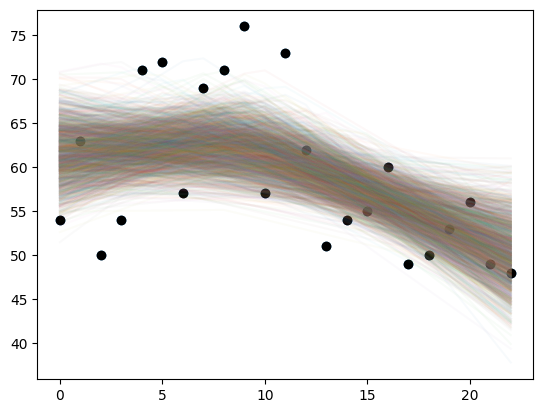

In [51]:
years = jnp.arange(len(datos))
plt.scatter(years, datos)

for i in range(samples_02['a0'].shape[0]):
    a0 = samples_02['a0'][i]
    b0 = samples_02['b0'][i]
    b1 = samples_02['b1'][i]
    knot = samples_02['knot'][i]
    λ = a0 + years * b0 + jnp.where(years > knot, (years - knot) * b1, 0)
    plt.plot(years, λ, alpha = .03)

plt.scatter(years, datos, c = 'black')    
plt.show()


Distribución _a posteriori_ del _codo_:

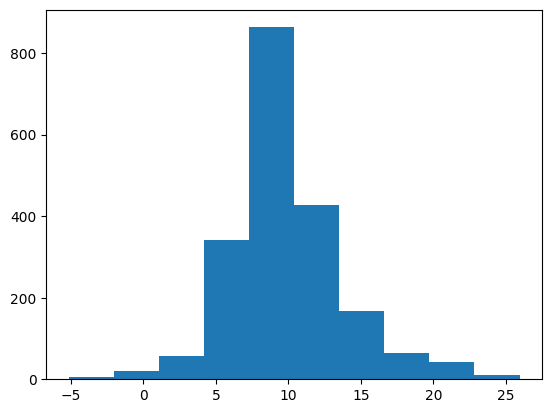

In [52]:
plt.hist(samples_02['knot']);

En lo que sigue, se muestra la _distribución predictiva a posteriori_ del modelo. Las bandas muestran los CI al 50% y 90% de la distribución _a posteriori_.

In [53]:
key = random.PRNGKey(1)

n_samples = 10000

sample_rows = sample_rows = random.choice(key, len(samples_02['a0']), (n_samples,))

def foo(my_sample):

    i = sample_rows[my_sample]

    a0 = samples_02['a0'][i]
    b0 = samples_02['b0'][i]
    b1 = samples_02['b1'][i]
    knot = samples_02['knot'][i]

    return a0 + years * b0 + jnp.where(years > knot, (years - knot) * b1, 0)


tmp = [foo(i) for i in sample_rows]

In [54]:
key = random.PRNGKey(1)

lambdas = jnp.array(tmp)
samples = random.poisson(key, lambdas)

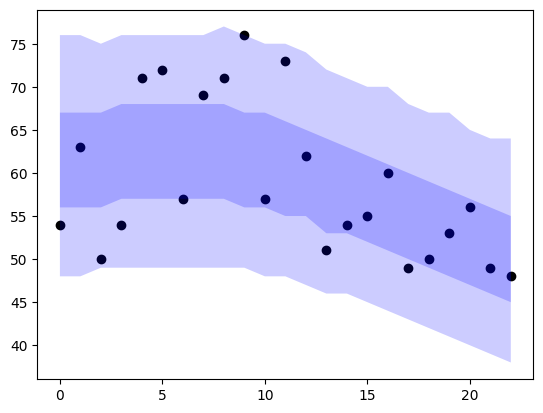

In [55]:
q1 = jnp.quantile(samples, jnp.array([.05, .25, .75, .95]), axis = 0)

plt.scatter(years, datos, c = 'black')    
plt.fill_between(years, q1[0, :], q1[3, :], facecolor='blue', alpha=0.2)
plt.fill_between(years, q1[1, :], q1[2, :], facecolor='blue', alpha=0.2)
plt.show()